In [2]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapter

/home/chongzheng_p23/data/miniconda3/envs/IP/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
# vae_model_path = "stabilityai/sd-vae-ft-mse"
# image_encoder_path = "models/image_encoder/"
# ip_ckpt = "models/ip-adapter_sd15.bin"
# device = "cuda"

base_model_path = "/data1/chongzheng/Models/SD/stable-diffusion-v1-5"
vae_model_path = "/data1/chongzheng/Projects/IP-Adapter/sd-vae-ft-mse"
image_encoder_path = "/data1/chongzheng/Projects/IP-Adapter/models/image_encoder/"
ip_ckpt = "/data1/chongzheng/Projects/IP-Adapter/ip-adapter_sd15.bin"
device = "cuda"
torch.cuda.set_device(6)

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [5]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


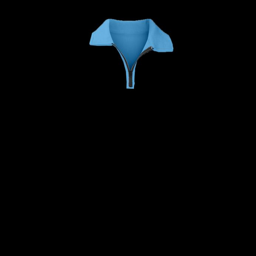

In [6]:
# read image prompt
image = Image.open("assets/images/1.png")
image.resize((256, 256))

In [7]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [14]:
# only image prompt
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=50)
grid = image_grid(images, 1, 4)
grid

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:4 and cuda:6! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)

  0%|          | 0/50 [00:00<?, ?it/s]

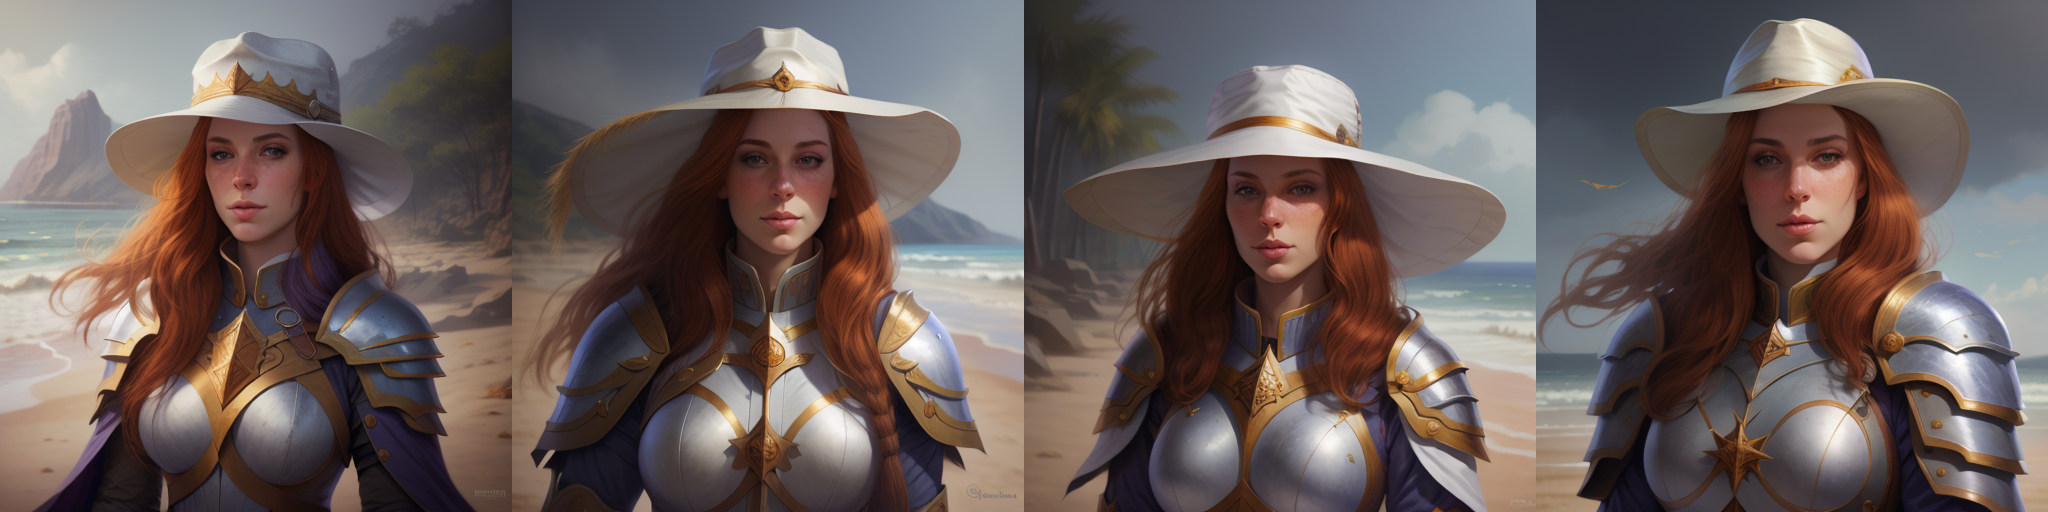

In [8]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42,
        prompt="best quality, high quality, wearing a hat on the beach", scale=0.6)
grid = image_grid(images, 1, 4)
grid

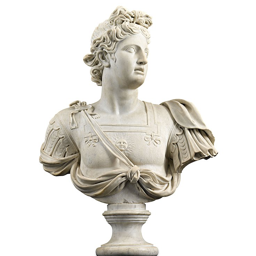

In [9]:
# read image prompt
image = Image.open("assets/images/statue.png")
image.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

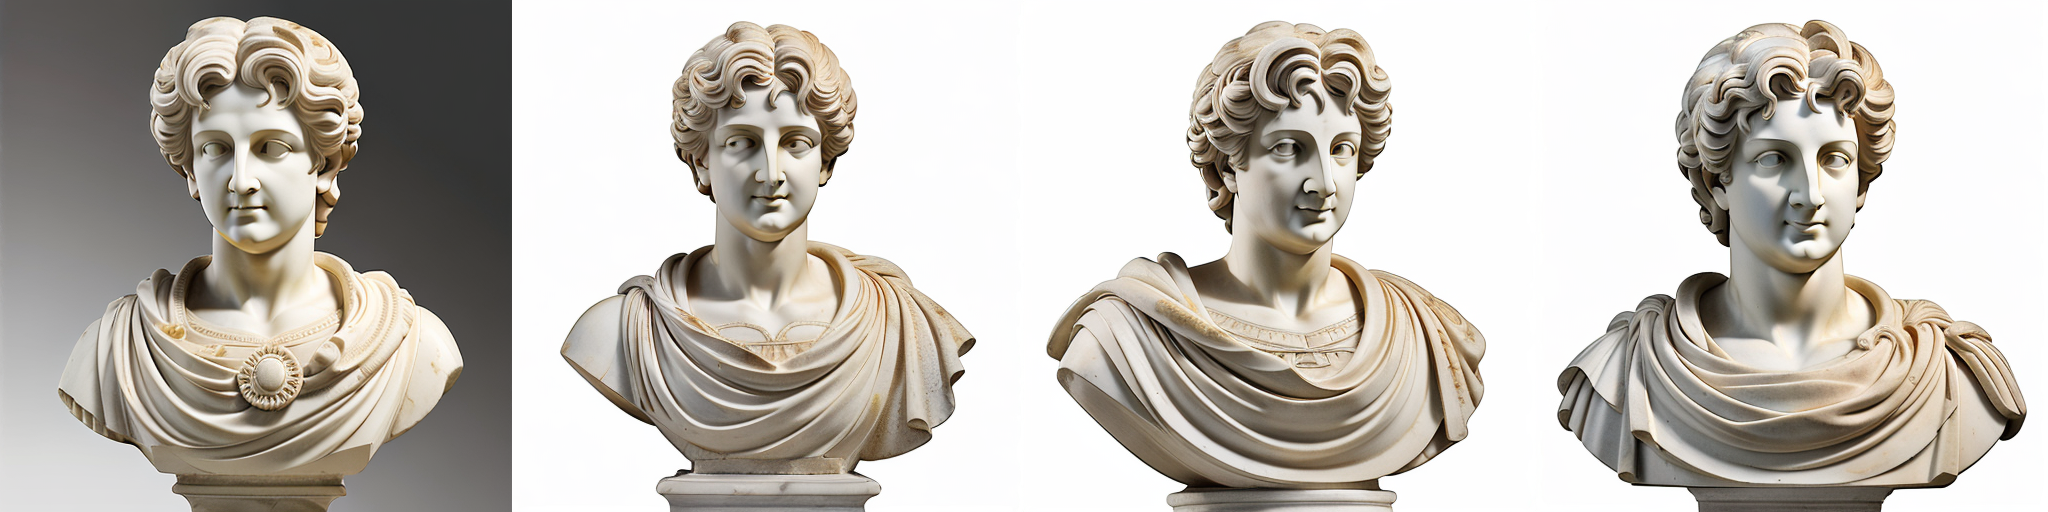

In [10]:
# only image prompt
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

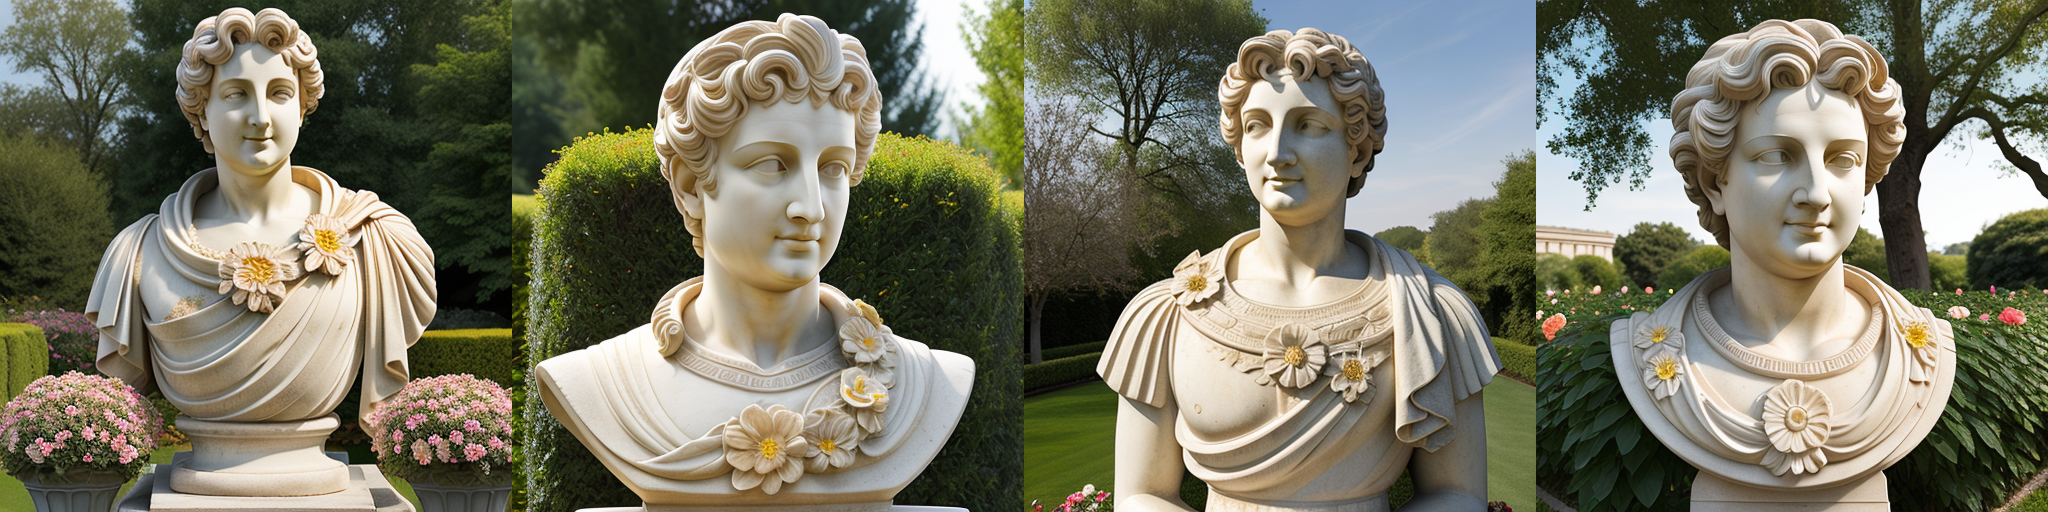

In [11]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42,
        prompt="best quality, high quality, in a garden with flowers", scale=0.5)
grid = image_grid(images, 1, 4)
grid